## Insight Project

## Exploratory Data Analysis

### Overview

The project objective is answer main two questions, in the context of a company that buys houses to sell.

1. Whith houses should the buy and at what purchase price?

2. With the house purchased, what is the best moment to sell and at what price?

* Will be used the data from <https://www.kaggle.com/harlfoxem/housesalesprediction>

### Environment Setup

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns

### Import DATA

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

### Clearing DATA

In [3]:
# Are there empty row for the features?
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [4]:
# What are the data type of the features?
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
# It's necessary converting feature date to datetime, because will be use for calculate the seasons.
df['date'] =  pd.to_datetime(df['date'])

<AxesSubplot:xlabel='price'>

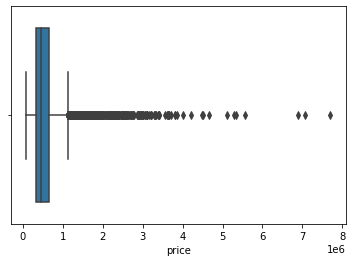

In [6]:
# Are there outlier price on dataframe?
sns.boxplot(x=df['price'])

In [7]:
#There are outliers, it's necessary remove them.
price = df['price'].sort_values()
Q1 = price.quantile(.25)
Q3 = price.quantile(.75)
IIQ = Q3 - Q1
inferior_limit = Q1 - 1.5 * IIQ
upper_limit = Q3 + 1.5 * IIQ
print(f'Inferior Limit {inferior_limit}\nUpper Limit {upper_limit}')
df = df[df['price'] < upper_limit]

Inferior Limit -162625.0
Upper Limit 1129575.0


## Answering business questions

#### 1) Whith houses should buy and at what purchase price?

In [8]:
# Suggestion of houses that should to buy, because they're price are under median and with good conditions.
# It's generate a report with the sugestions, called houses_to_buy.
median_price_zipcode = df[['zipcode','price']].groupby(['zipcode']).median().reset_index()
median_price_zipcode.rename(columns = {'price':'median_price_zipcode'}, inplace=True)
df = df.merge(median_price_zipcode, on='zipcode', how='inner')

df['status'] = None
for i in range(len(df)):
  if (df.loc[i, 'price'] < df.loc[i,'median_price_zipcode']) and (df.loc[i,'condition'] >= 3):
    df['status'].iloc[i] = 'buy'
  else:
    df['status'].iloc[i] = 'not_buy'

houses_to_buy = df[df['status'] == 'buy']
houses_to_buy = houses_to_buy[['id', 'zipcode', 'price', 'median_price_zipcode', 'condition', 'status']].reset_index()
houses_to_buy.to_csv('data/houses_to_buy.csv', index=False)
houses_to_buy.head(10)

C:\Users\Robson Silva\AppData\Local\Temp\ipykernel_11452\626925277.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'].iloc[i] = 'buy'
C:\Users\Robson Silva\AppData\Local\Temp\ipykernel_11452\626925277.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'].iloc[i] = 'not_buy'


,index,id,zipcode,price,median_price_zipcode,condition,status
0,0,7129300520,98178,221900.0,277554.0,3,buy
1,1,4060000240,98178,205425.0,277554.0,4,buy
2,3,2976800796,98178,236000.0,277554.0,3,buy
3,4,6874200960,98178,170000.0,277554.0,3,buy
4,5,4268200055,98178,245000.0,277554.0,3,buy
5,6,3969300030,98178,165000.0,277554.0,3,buy
6,7,3969300030,98178,239900.0,277554.0,3,buy
7,10,1180003090,98178,190000.0,277554.0,3,buy
8,11,561000075,98178,260000.0,277554.0,4,buy
9,14,3348401740,98178,188000.0,277554.0,3,buy


In [9]:
df['median_price_zipcode']

0        277554.0
1        277554.0
2        277554.0
3        277554.0
4        277554.0
           ...   
20462    906250.0
20463    906250.0
20464    906250.0
20465    906250.0
20466    906250.0
Name: median_price_zipcode, Length: 20467, dtype: float64

#### 2) With the house purchased, what is the best moment to sell and at what price?

In [10]:
# New column called season based from date, considering north hemisphere seasons.
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start= year +'-03-21 00:00:00', end=year + '-06-20 00:00:00'),
               'summer': pd.date_range(start= year + '-06-21 00:00:00', end= year + '-09-22 00:00:00'),
               'autumn': pd.date_range(start= year + '-09-23 00:00:00', end= year + '-12-20 00:00:00')}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

df['season'] = df.date.map(season_of_date)

In [11]:
# Suggestion of houses price to sell, the suggestion are considering the median price and the seasons of the year.
median_price_zipcode_season = df[['zipcode', 'season','price']].groupby(['zipcode', 'season']).median().reset_index()
median_price_zipcode_season.rename(columns = {'price':'median_price_zipcode_season'}, inplace=True)
median_price_zipcode_season.head(10)
df = df.merge(median_price_zipcode_season, on=['zipcode','season'], how='inner')
df[['price_sale', 'profit']] = np.NaN, np.NaN
for i in range(len(df)):
 if (df.loc[i, 'price'] >= df.loc[i,'median_price_zipcode_season']) and (df.loc[i, 'status'] == 'buy'):
   df['price_sale'].iloc[i] = df.loc[i, 'price'] * 1.1
   df['profit'].iloc[i] = (df.loc[i, 'price'] * 1.1) - df.loc[i, 'price']
 elif (df.loc[i, 'price'] < df.loc[i,'median_price_zipcode_season']) and (df.loc[i, 'status'] == 'buy'):
   df['price_sale'].iloc[i] = df.loc[i, 'price'] * 1.3
   df['profit'].iloc[i] = (df.loc[i, 'price'] * 1.3) - df.loc[i, 'price']
 else:
    pass
houses_to_sell = df[df['status'] == 'buy']
houses_to_sell = houses_to_sell[['id', 'zipcode', 'season', 'median_price_zipcode_season','price', 'price_sale', 'profit']].reset_index()
houses_to_sell.rename(columns = {'median_price_zipcode_season': 'median_price', 'price': 'price_bought'}, inplace=True)
houses_to_sell.to_csv('data/houses_to_sell.csv', index=False)
houses_to_sell.head()

C:\Users\Robson Silva\AppData\Local\Temp\ipykernel_11452\2983120236.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_sale'].iloc[i] = df.loc[i, 'price'] * 1.3
C:\Users\Robson Silva\AppData\Local\Temp\ipykernel_11452\2983120236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit'].iloc[i] = (df.loc[i, 'price'] * 1.3) - df.loc[i, 'price']
C:\Users\Robson Silva\AppData\Local\Temp\ipykernel_11452\2983120236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,index,id,zipcode,season,median_price,price_bought,price_sale,profit
0,0,7129300520,98178,autumn,284000.0,221900.0,288470.0,66570.0
1,1,2976800796,98178,autumn,284000.0,236000.0,306800.0,70800.0
2,2,3352402236,98178,autumn,284000.0,252500.0,328250.0,75750.0
3,5,179000350,98178,autumn,284000.0,194000.0,252200.0,58200.0
4,8,179003055,98178,autumn,284000.0,210000.0,273000.0,63000.0


### Potential Profit Using Generated Reports above

In [12]:
#Total potential profit if sell all the houses that was indicated in the first business question, using the suggested price.
print(f'Total profit: {houses_to_sell.profit.sum():,}')

Total profit: 1,061,932,596.8
